In [1]:
import json
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [2]:
class CustomDataset(Dataset):
    def __init__(self, json_path, image_folder, transform=None):
        with open(json_path, 'r') as f:
            data = json.load(f)

        self.image_info_list = data['description']
        self.annotations = data['annotations']
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_info_list)

    def __getitem__(self, idx):
        image_name = self.image_info_list[idx]['image']
        image_path = Path(self.image_folder) / image_name

        image = Image.open(image_path).convert("RGB")

        # 바운딩 박스 좌표 및 질병 정보 가져오기
        annotation = next(item for item in self.annotations if item['image'] == image_name)
        points_list = annotation["points"]

        # 딕셔너리에서 값 가져오기
        points = points_list[0]
        xtl, ytl, xbr, ybr = points["xtl"], points["ytl"], points["xbr"], points["ybr"]

        disease_label = annotation["disease"]

        # 필요에 따라 이미지 크기 조정
        if self.transform:
            image = self.transform(image)

        return {"image": image, "bbox": (xtl, ytl, xbr, ybr), "disease": disease_label}


In [3]:
# 모델 정의
class TomatoCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(TomatoCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# 훈련 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 훈련 데이터셋 객체 생성
train_dataset = CustomDataset('./data/labeled_data.json', './data/train/', transform=transform)
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# 테스트 데이터셋 및 DataLoader 설정
test_dataset = CustomDataset('./data/test_labeled_data.json', './data/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


In [5]:
# 모델, 손실 함수, 옵티마이저 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TomatoCNN(num_classes=20)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

In [6]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [7]:
# 훈련과 테스트 손실 및 정확도 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []  # 추가
test_accuracies = []  # 추가

# 훈련 및 평가 함수 수정
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=5):
    for epoch in range(epochs):
        # 훈련 단계
        model.train()
        train_loss, train_correct = 0, 0
        for batch_idx, data in enumerate(train_loader):
            images, labels = data["image"].to(device), data["disease"].to(device)
            bbox = data["bbox"]  # 바운딩 박스 정보

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx}, Train Loss: {loss.item():.4f}")

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Train Accuracy: {100 * train_accuracy:.2f}%, Average Train Loss: {train_loss:.4f}")

        # 훈련 손실 및 정확도 저장
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # 추가

        # 테스트 단계 (테스트 데이터셋은 labeled_data.json이 없다고 가정)
        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data["image"].to(device), data["disease"].to(device)
                bbox = data["bbox"]  # 바운딩 박스 정보

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = test_correct / len(test_loader.dataset)
        print(f"Epoch {epoch + 1}, Test Accuracy: {100 * test_accuracy:.2f}%, Average Test Loss: {test_loss:.4f}")
        print("=" * 50)

        # 테스트 손실 및 정확도 저장
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)  # 추가

In [8]:
# 훈련과 평가 실행
train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=5)

Epoch 1, Batch 0, Train Loss: 3.0059
Epoch 1, Batch 100, Train Loss: 0.1168
Epoch 1, Batch 200, Train Loss: 0.1868
Epoch 1, Train Accuracy: 94.43%, Average Train Loss: 0.0029
Epoch 1, Test Accuracy: 98.52%, Average Test Loss: 0.0009
Epoch 2, Batch 0, Train Loss: 0.0734
Epoch 2, Batch 100, Train Loss: 0.0991
Epoch 2, Batch 200, Train Loss: 0.1016
Epoch 2, Train Accuracy: 96.55%, Average Train Loss: 0.0016
Epoch 2, Test Accuracy: 98.37%, Average Test Loss: 0.0009
Epoch 3, Batch 0, Train Loss: 0.0372
Epoch 3, Batch 100, Train Loss: 0.0414
Epoch 3, Batch 200, Train Loss: 0.1282
Epoch 3, Train Accuracy: 98.06%, Average Train Loss: 0.0009
Epoch 3, Test Accuracy: 98.63%, Average Test Loss: 0.0007
Epoch 4, Batch 0, Train Loss: 0.0179
Epoch 4, Batch 100, Train Loss: 0.0430
Epoch 4, Batch 200, Train Loss: 0.0157
Epoch 4, Train Accuracy: 99.09%, Average Train Loss: 0.0004
Epoch 4, Test Accuracy: 98.30%, Average Test Loss: 0.0011
Epoch 5, Batch 0, Train Loss: 0.0060
Epoch 5, Batch 100, Train Loss:

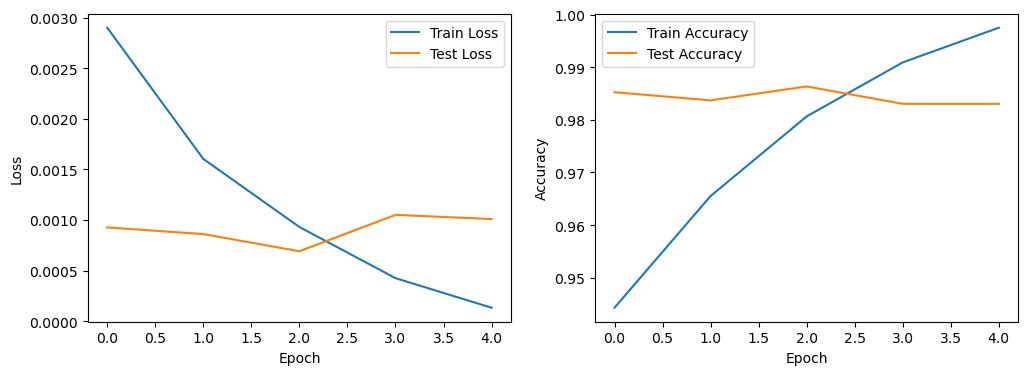

In [9]:
import matplotlib.pyplot as plt

# 훈련 및 테스트 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')  # 추가
plt.plot(test_accuracies, label='Test Accuracy')  # 추가
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
import os
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'model.pth')
# 학습된 모델 저장 (적절한 경로를 지정하세요)
torch.save(model.state_dict(), 'model.pth')
print("Save PyTorch Model State to model.pth")

Save PyTorch Model State to model.pth
